Aluno: Nelson de Campos Nolasco.

Disciplina: Deep Learning.

Professor: Rafael Glater

In [ ]:
%matplotlib inline # as saídas vão ser na própria tela do notebbok

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import random

# Baixando o dataset

In [3]:
%tensorflow_version 2.x # usando tensorflow para baixar dataset
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() 

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # usando tensorflow para baixar dataset`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
11493376/11490434 [==============================] - 0s 0us/step


## Conferindo:

In [4]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [5]:
y_train[0] 

5

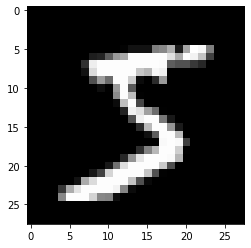

In [6]:
plt.imshow(x_train[0], cmap='Greys')
plt.gray()
plt.show()

# Funções úteis

In [7]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z)) # fórmula da sigmod

def sigmoidPrime(z):
    return sigmoid(z) * (1 - sigmoid(z)) # derivada parcial da sigmod

def softmax(x, axis=-1):  # fórmula da softmx para obter as saídas
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=axis, keepdims=True)

def one_hot(values, depth): # transformar o número 5 do y_train[0] em um vetor
# de zeros e um.
    return np.eye(depth)[values]

def shuffleData(X, y):
    c = list(zip(X, y))
    random.shuffle(c)
    X, y = zip(*c)
    return (np.asarray(X), np.asarray(y))

def cost(X, y, w1, b1, w2, b2, reg_lambda):
    a1 = X
    z2 = a1.dot(w1) + b1
    a2 = sigmoid(z2)
    z3 = a2.dot(w2) + b2
    a3 = softmax(z3)

    sample_size = len(X)

    # comput the difference between each output unit K and unit in y
    diff_Ks = -y * np.log(a3) - (1 - y) * np.log(1 - a3)
    # first sum the Ks, then sum all samples
    J = sum(np.sum(diff_Ks, axis=0)) / sample_size
    
    # regularization part
    sum1 = sum(w1 ** 2)
    sum2 = sum(w2 ** 2)
    sum3 = sum(np.concatenate((sum1, sum2)))
    J = J + ((reg_lambda * sum3) / (2 * sample_size))
    return J

def predict(X, w1, b1, w2, b2):
    a1 = X
    z2 = a1.dot(w1) + b1
    a2 = sigmoid(z2)
    z3 = a2.dot(w2) + b2
    a3 = softmax(z3)
    return np.argmax(a3, axis=1)


def evaluatePredictions(predictions, y): # para saber a porcentafem de acerto
    return np.equal(predictions, y).sum() / float(len(y))

# Configurando a rede neural

In [8]:
input_layer_size = 784 # imagem de 28 x 28
hidden_layer_size = 30 # tamanho da rede neural
output_layer_size = 10 # saida igual os números possíveis
reg_lambda = 5.0 # regularização
lr = 0.1 #learning rate
batch_size = 10 # quantas porção de treino vai pegar a cada vez
epochs = 30 # quantas vezes irão passar pelo 60 mil dados
training_size = float(len(x_train)) # tamanho do treino
test_size = float(len(x_test)) # // teste

# Inicializando os pesos a partir de uma distribuição uniforme: np.random.uniform
# (Também podemos inicializar de uma distribuição normal padrão: np.random.randn)
w1 = np.random.uniform(-0.12, 0.12, (input_layer_size, hidden_layer_size))
w2 = np.random.uniform(-0.12, 0.12, (hidden_layer_size, output_layer_size))
b1 = np.random.uniform(-0.12, 0.12, (1, hidden_layer_size))
b2 = np.random.uniform(-0.12, 0.12, (1, output_layer_size))

In [9]:
w1.shape

(784, 30)

# Tratando os dados

Temos que fazer alguns tratamentos nos dados para executar o treino de maneira adequada:

- Converter os labels para one hot encoding. Ou seja, o label "5", precisa ser transformado em: "[0,0,0,0,0,1,0,0,0,0]". A primeira posição representa o "0" e a última o "9".

- Temos que mudar a forma dos dados de entrada, ao invés de termos uma matriz de 28x28, teremos uma matriz de 1x784.

- Normalizar os dados: Os valores de entrada representam os pixels, que vão de 0 a 255. Para ter um bom resultado o ideial é que os dados não tenham uma variação tão grande e portanto vamos dividir tudo por 255. Dessa forma, os valores vão variar de 0 a 1.

In [11]:
y_train_one_hot = one_hot(y_train, depth=10)  # fazer one_hot de y_train
x_train_reshaped = x_train.reshape((int(training_size), 784)) # fazer reshape de x_train para 784
x_train_reshaped = x_train_reshaped / 255.0 # normalizar dividindo por 255

x_test_reshaped = x_test.reshape((int(test_size), 784))# reshape de x_test para 784
x_test_reshaped = x_test_reshaped / 255.0 # normalizar dividindo por 255

## Conferindo

In [12]:
print(y_train[67])
print(y_train_one_hot[67])

1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
x_train_reshaped.shape # 60.000 exemplos

(60000, 784)

# Treinando

In [14]:
for e in range(epochs):  #epochs passar 30 vezes em 60.000 exemplos
    X, y = shuffleData(x_train_reshaped, y_train_one_hot) #shuffleData = embaralhar os dados a cada vez
    batches = [(X[i:i + batch_size], y[i:i + batch_size])
                for i in range(0, int(training_size), batch_size)]
    for batch in batches: # batches = lotes de 10 
        Xi = batch[0] # primeiro lote 10 exemplos
        yi = batch[1] # respectivos 10 layer dos exemplos

        # STEP 1: feedforward --------------------------------------------
        a1 = Xi
        z2 = a1.dot(w1) + b1
        a2 = sigmoid(z2)
        z3 = a2.dot(w2) + b2
        a3 = softmax(z3)

        # STEP 2: backpropagation ----------------------------------------
        delta3 = (a3 - yi)
        grad_w2 = (delta3.T).dot(a2) / batch_size
        grad_b2 = np.sum(delta3, axis=0)/ batch_size

        delta2 = delta3.dot(w2.T)* sigmoidPrime(z2)
        grad_w1 = (delta2.T).dot(a1) / batch_size
        grad_b1 = np.sum(delta2, axis=0) / batch_size

        # regularization of backpropagation
        grad_w2 = grad_w2.T + (reg_lambda * w2) / training_size
        grad_w1 = grad_w1.T + (reg_lambda * w1) / training_size

        # STEP 3: update weights -----------------------------------------
        w1 = w1 - lr * grad_w1
        b1 = b1 - lr * grad_b1   
        w2 = w2 - lr * grad_w2 
        b2 = b2 - lr * grad_b2

    # Let's check the cost in this epoch
    print("Epoch: {0} - cost: {1}".format(e, cost(X, y, w1, b1, w2, b2, reg_lambda)))

Epoch: 0 - cost: 0.44946588885707606
Epoch: 1 - cost: 0.36753515915041457
Epoch: 2 - cost: 0.3254667914844541
Epoch: 3 - cost: 0.28659767359886046
Epoch: 4 - cost: 0.26572187107681916
Epoch: 5 - cost: 0.25163497152360553
Epoch: 6 - cost: 0.24196797263769945
Epoch: 7 - cost: 0.22933171600053773
Epoch: 8 - cost: 0.2224810741425167
Epoch: 9 - cost: 0.22312708900293374
Epoch: 10 - cost: 0.21443639170564222
Epoch: 11 - cost: 0.21326474693352662
Epoch: 12 - cost: 0.20726415675171578
Epoch: 13 - cost: 0.20993426994575476
Epoch: 14 - cost: 0.20928935904468235
Epoch: 15 - cost: 0.2029880404145361
Epoch: 16 - cost: 0.19505891434136946
Epoch: 17 - cost: 0.19875880042046304
Epoch: 18 - cost: 0.1930378597003413
Epoch: 19 - cost: 0.19272370130224203
Epoch: 20 - cost: 0.1968643031886249
Epoch: 21 - cost: 0.19008070072182856
Epoch: 22 - cost: 0.19298471404700246
Epoch: 23 - cost: 0.18394327263136687
Epoch: 24 - cost: 0.1858993479931659
Epoch: 25 - cost: 0.18148341973329102
Epoch: 26 - cost: 0.18430872

In [15]:
# Comparação com o que o modelo preveu
# com o valor real 
predictions = predict(x_test_reshaped, w1, b1, w2, b2)
print("Precision in the test set: {0}".format(evaluatePredictions(predictions, y_test)))
# Acertou dos 10 números 96 porcentos.

Precision in the test set: 0.97


# Analisando os casos de erro

Abaixo estão os índices que a rede classificou errado:

In [16]:
np.where(np.not_equal(predictions, y_test)==True)

(array([   8,   61,  247,  259,  290,  321,  324,  340,  381,  445,  447,
         495,  543,  582,  591,  619,  646,  659,  684,  691,  707,  717,
         740,  846,  882,  939,  947,  951,  956,  965, 1014, 1044, 1050,
        1112, 1114, 1181, 1182, 1194, 1198, 1224, 1226, 1232, 1242, 1247,
        1283, 1289, 1319, 1325, 1326, 1328, 1476, 1494, 1500, 1522, 1527,
        1530, 1549, 1553, 1587, 1678, 1681, 1709, 1717, 1737, 1754, 1790,
        1850, 1857, 1878, 1901, 1940, 1941, 1981, 1982, 1984, 2016, 2024,
        2035, 2040, 2044, 2053, 2093, 2098, 2109, 2118, 2129, 2135, 2182,
        2185, 2186, 2189, 2266, 2272, 2293, 2369, 2387, 2414, 2422, 2454,
        2462, 2488, 2560, 2574, 2598, 2607, 2654, 2720, 2771, 2896, 2921,
        2927, 2939, 2976, 2995, 3060, 3062, 3073, 3117, 3218, 3225, 3254,
        3289, 3330, 3336, 3375, 3376, 3384, 3422, 3503, 3520, 3533, 3549,
        3558, 3559, 3567, 3597, 3604, 3674, 3681, 3702, 3718, 3751, 3757,
        3767, 3780, 3808, 3811, 3853, 

Vamos ver os exemplos desses índices:

Valor real: 3
Valor predito: 9
Imagem:


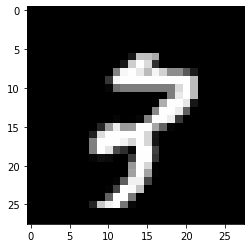

In [17]:
num_example = 9905
print("Valor real:", y_test[num_example])
print("Valor predito:", predictions[num_example])
print("Imagem:")
plt.imshow(x_test[num_example], cmap='Greys')
plt.gray()
plt.show()